In [15]:
import os
import numpy as np
import pandas as pd
import rasterio as rio
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import rioxarray
import geopandas as gpd

In [16]:
# function to rewrite coordinates from metadata
def coord_range(ds):
    latrange = np.linspace(float(ds.attrs['Y_FIRST']),
                           ((float(ds.attrs['Y_STEP'])*float(ds.attrs['LENGTH']))+float(ds.attrs['Y_FIRST'])),
                           int(ds.attrs['LENGTH']))
    lonrange = np.linspace(float(ds.attrs['X_FIRST']),
                           ((float(ds.attrs['X_STEP'])*float(ds.attrs['WIDTH']))+float(ds.attrs['X_FIRST'])),
                           int(ds.attrs['WIDTH']))
    return latrange, lonrange

def mintpy2d_to_xarray(fn, crs):
    ds = xr.open_dataset(fn, phony_dims='sort')
    ds = ds.rename_dims({'phony_dim_0':'y',
                         'phony_dim_1':'x'
                        })
    latrange, lonrange = coord_range(ds)
    ds = ds.assign_coords({'y': ('y', latrange),
                          'x': ('x', lonrange)})
    ds = ds.rio.write_crs(crs)
    
    return ds

In [17]:
mintpy_path = '/mnt/c/Users/qbren/Desktop/taco/projects/fusits/nbs/imja/hyp3-isce2/mintpy_igrams'
crs = 32645
vel_ds = mintpy2d_to_xarray(f'{mintpy_path}/velocity.h5', crs)
vel_ds = vel_ds.velocity.rio.write_nodata(0, inplace=True)
vel_ds = vel_ds * -1 # keep normal insar sign convention
vel_ds.rio.to_raster(f'{mintpy_path}/mean_velocity.tif')

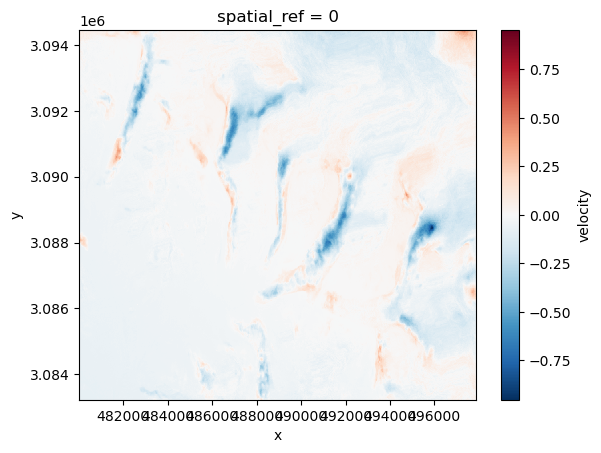

In [18]:
vel_ds.plot()

In [24]:
# assuming only vertical displacement
theta = (np.pi/2) - 0.945
gamma = 2.955 - (np.pi/2) 

In [26]:
los = np.array([np.cos(gamma)*np.sin(theta),
                np.sin(gamma)*np.sin(theta),
                np.cos(theta)])

In [27]:
los

array([0.1086622 , 0.57557558, 0.81049693])

In [ ]:
# export InSAR spatial coherence
mintpy_path = '/mnt/Backups/gbrench/repos/fusits/nbs/imja/agu_push/AT12/mintpy_igrams'
cor_ds = mintpy2d_to_xarray(f'{mintpy_path}/avgSpatialCoh.h5', crs)
#vel_ds.rio.to_raster(f'{mintpy_path}/offset_mean_velocity.tif')

In [ ]:
f, ax = plt.subplots()
ax.imshow(1- cor_ds.coherence, cmap='Blues', vmin=0, vmax=1)

In [11]:
crs = 32645
comp_ds = mintpy2d_to_xarray(f'{mintpy_path}/maskConnComp.h5', crs)
(comp_ds.mask*1.1).rio.to_raster(f'{mintpy_path}/maskConnComp.tif')

In [6]:
comp_ds

<xarray.Dataset>
Dimensions:      (y: 1972, x: 5142)
Coordinates:
  * y            (y) float64 3.107e+06 3.107e+06 ... 3.068e+06 3.068e+06
  * x            (x) float64 4.166e+05 4.166e+05 ... 5.194e+05 5.195e+05
    spatial_ref  int64 0
Data variables:
    mask         (y, x) bool ...
Attributes: (12/137)
    ALOOKS:                                        1
    ANTENNA_SIDE:                                  -1
    AZIMUTH_PIXEL_SIZE:                            14.1
    BANDS:                                         1
    CENTER_LINE_UTC:                               1546.868609
    DATA_TYPE:                                     float32
    ...                                            ...
    mintpy.unwrapError.bridgePtsRadius:            auto
    mintpy.unwrapError.connCompMinArea:            auto
    mintpy.unwrapError.method:                     bridging
    mintpy.unwrapError.numSample:                  auto
    mintpy.unwrapError.ramp:                       auto
    mintpy.unwrapError.waterMaskFile:              auto